In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix
import warnings
warnings.filterwarnings("ignore")

## 1.Explore data

In [24]:
df = pd.read_csv('uci-secom.csv')
df.sample(5)

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
615,2008-08-31 22:32:00,2956.18,2435.99,2171.8556,940.9917,1.2906,100.0,103.4733,0.1234,1.4635,...,40.2536,0.4983,0.0100,0.0026,2.0112,0.0192,0.0077,0.0021,40.2536,-1
1404,2008-07-10 17:06:00,2893.19,2498.09,2200.2111,1048.3108,1.6485,100.0,98.3222,0.1214,1.5471,...,NaN,0.4954,0.0106,0.0030,2.1397,0.0458,0.0277,0.0100,60.5430,-1
225,2008-08-17 01:53:00,2999.86,2287.90,2197.6444,1247.0334,0.7865,100.0,99.9211,0.1203,1.4785,...,31.4679,0.5047,0.0124,0.0038,2.4550,0.0265,0.0083,0.0029,31.4679,-1
142,2008-06-08 20:17:00,2989.63,2364.73,2196.6555,1066.1908,1.2188,100.0,101.8900,0.1211,1.4921,...,31.2736,0.5064,0.0117,0.0028,2.3099,0.0348,0.0109,0.0040,31.2736,-1
1212,2008-01-10 07:19:00,3070.43,2446.38,2255.5222,1763.0739,1.2226,100.0,101.5878,0.1200,1.6122,...,41.0611,0.4983,0.0113,0.0031,2.2765,0.0212,0.0087,0.0032,41.0611,-1


In [25]:
target = 'Pass/Fail'

In [26]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,Pass/Fail
count,1561.000000,1560.000000,1553.000000,1553.000000,1553.000000,1553.0,1553.000000,1558.000000,1565.000000,1565.000000,...,618.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1567.000000
mean,3014.452896,2495.850231,2200.547318,1396.376627,4.197013,100.0,101.112908,0.121822,1.462862,-0.000841,...,97.934373,0.500096,0.015318,0.003847,3.067826,0.021458,0.016475,0.005283,99.670066,-0.867262
std,73.621787,80.407705,29.513152,441.691640,56.355540,0.0,6.237214,0.008961,0.073897,0.015116,...,87.520966,0.003404,0.017180,0.003720,3.578033,0.012358,0.008808,0.002867,93.891919,0.498010
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.053400,...,0.000000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000,-1.000000
25%,2966.260000,2452.247500,2181.044400,1081.875800,1.017700,100.0,97.920000,0.121100,1.411200,-0.010800,...,46.184900,0.497900,0.011600,0.003100,2.306500,0.013425,0.010600,0.003300,44.368600,-1.000000
50%,3011.490000,2499.405000,2201.066700,1285.214400,1.316800,100.0,101.512200,0.122400,1.461600,-0.001300,...,72.288900,0.500200,0.013800,0.003600,2.757650,0.020500,0.014800,0.004600,71.900500,-1.000000
75%,3056.650000,2538.822500,2218.055500,1591.223500,1.525700,100.0,104.586700,0.123800,1.516900,0.008400,...,116.539150,0.502375,0.016500,0.004100,3.295175,0.027600,0.020300,0.006400,114.749700,-1.000000
max,3356.350000,2846.440000,2315.266700,3715.041700,1114.536600,100.0,129.252200,0.128600,1.656400,0.074900,...,737.304800,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800,1.000000


In [30]:
def find_percent_null(data: pd.DataFrame):
    '''
    Find the percentage of null values in each column of a dataframe

    Parameters
    ----------
    data: pd.DataFrame
        The dataframe to be analyzed

    Returns
    -------
    percent_null: pd.DataFrame
        A dataframe containing the percentage of null values in each column

    '''
    result_dict = {'Column_Name':[],'Number_Null_Value':[],'Percent_Null (%)':[]}
    for col in data.columns:
        number_null_value = data[col].isnull().sum()
        if  number_null_value> 0:
            result_dict['Column_Name'].append(col)
            result_dict['Number_Null_Value'].append(number_null_value)
            result_dict['Percent_Null (%)'].append(number_null_value*100/data.shape[0])
    result_table = pd.DataFrame(result_dict)
    return result_table

In [31]:
null_table = find_percent_null(df).sort_values(by = 'Percent_Null (%)',ascending=False)
null_table[null_table['Percent_Null (%)'] > 50]

,Column_Name,Number_Null_Value,Percent_Null (%)
269,292,1429,91.193363
270,293,1429,91.193363
145,157,1429,91.193363
146,158,1429,91.193363
335,358,1341,85.577537
84,85,1341,85.577537
458,492,1341,85.577537
208,220,1341,85.577537
481,518,1018,64.964901
231,246,1018,64.964901


In [32]:
df.skew()

0             0.513657
1            -0.043066
2            -0.305764
3             1.711627
4            19.645262
               ...    
586           1.438025
587           1.947408
588           2.029372
589           2.714475
Pass/Fail     3.487359
Length: 591, dtype: float64

In [33]:
# Draw distribution of chossen column
def draw_distribution(data : pd.DataFrame,columns : list,bins = 40,figsize = (10,12),subplotsize = (1,1)):
    '''
    Draw distribution of data in list columns input

    Parameters:
    ----------
    data : pd.DataFrame
        The data for drawing 
    column: str
        Column was be choosed for drawing data
    '''
    fig = plt.figure(figsize=figsize)
    rows = subplotsize[0]
    cols = subplotsize[1]
    for i,col in enumerate(columns):
        fig.add_subplot(rows,cols,i+1)
        plt.hist(data[col])
        plt.title(col)
    plt.show()

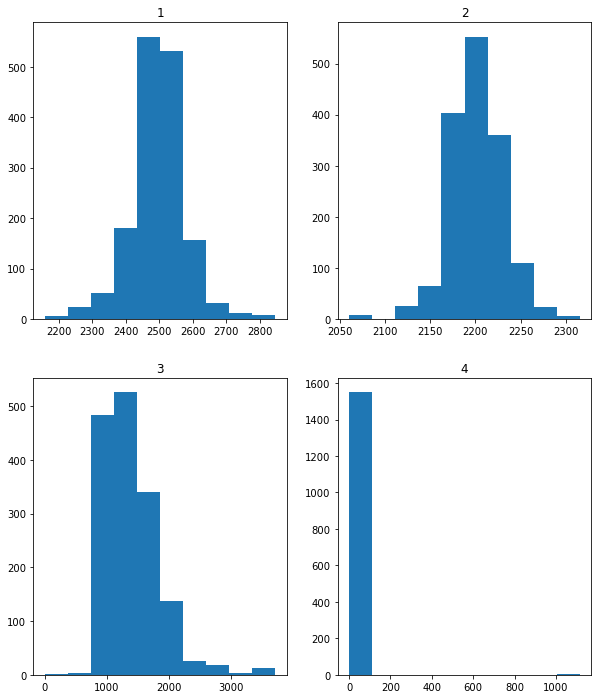

In [36]:
draw_distribution(df,['1','2','3','4'],subplotsize=(2,2))

In [37]:
corr_matrix = df[['1','2','3','4',target]].corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,1,2,3,4,Pass/Fail
1,1.000000,0.005802,-0.007603,-0.001641,-0.002615
2,0.005802,1.000000,0.298935,0.095891,-0.000957
3,-0.007603,0.298935,1.000000,-0.058483,-0.024631
4,-0.001641,0.095891,-0.058483,1.000000,-0.013760
Pass/Fail,-0.002615,-0.000957,-0.024631,-0.013760,1.000000


In [38]:
df[target].value_counts()

-1    1463
 1     104
Name: Pass/Fail, dtype: int64

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

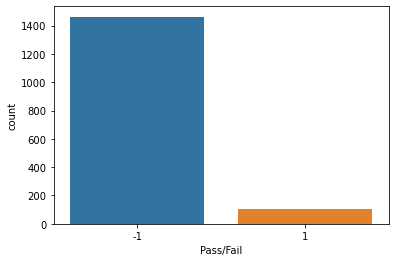

In [39]:
sns.countplot(df[target])
plt.xlabel

**We can see imbalance data**

## 2.Processing data

In [40]:
null_percent_table = find_percent_null(df)
null_percent_table = null_percent_table.sort_values(by = 'Percent_Null (%)',ascending= False)
null_percent_table.head(10)

,Column_Name,Number_Null_Value,Percent_Null (%)
269,292,1429,91.193363
270,293,1429,91.193363
145,157,1429,91.193363
146,158,1429,91.193363
335,358,1341,85.577537
84,85,1341,85.577537
458,492,1341,85.577537
208,220,1341,85.577537
481,518,1018,64.964901
231,246,1018,64.964901


In [41]:
high_percent_null_column = null_percent_table[null_percent_table['Percent_Null (%)'] > 50]['Column_Name'].values
high_percent_null_column

array(['292', '293', '157', '158', '358', '85', '492', '220', '518',
       '246', '245', '516', '517', '110', '384', '382', '383', '109',
       '244', '111', '580', '578', '581', '579', '73', '72', '345', '346'],
      dtype=object)

In [42]:
# Drop cloumn that have high null value
df = df.drop(labels=high_percent_null_column,axis=1)

In [43]:
# Check data frame after drop
null_value = find_percent_null(df)
len(null_value[null_value['Percent_Null (%)']>50])

0

In [44]:
# Drop cloumn 'Time'
df = df.drop(labels='Time',axis = 1)

### 2.1 Processing null value

We fill 0 instead of mean because we want to detect all failed product. If we use mean to replace null, we have high probability machine will detect failed product to passed prodcut and it really dangerous so we imput 0 although passed product can be deteted failed product but we can find all failed prodcut

In [45]:
df.fillna(0,inplace=True)

In [46]:
sum(df.isnull().sum())

0

### 2.2 Normalize data

In [47]:
X = df.drop(target,axis = 1)
y = df[[target]]

In [48]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [49]:
X[:5]

array([[ 0.13999828,  0.42920791,  0.03273532, ..., -1.86846064,
        -1.84076867, -1.0611589 ],
       [ 0.46402024, -0.10587396,  0.23685169, ...,  0.41258698,
         0.25102908,  1.15695081],
       [-0.35125598,  0.40723307,  0.02641324, ...,  3.62421124,
         3.31899911, -0.17840653],
       [-0.07090329, -0.02598515,  0.08676611, ..., -0.17753479,
        -0.30678365, -0.27446928],
       [ 0.14654367,  0.09834047,  0.25093078, ..., -0.17753479,
        -0.30678365, -0.27446928]])

### 2.4 Processing imbalance data

<AxesSubplot:xlabel='Pass/Fail', ylabel='count'>

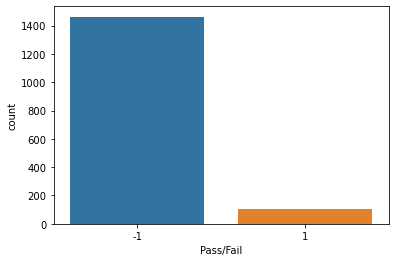

In [50]:
sns.countplot(df[target])

In [51]:
passed_indices = y[y[target] == -1].index
failed_indices = y[y[target] == 1].index

In [52]:
passed_indices[:5],failed_indices[:5]

(Int64Index([0, 1, 3, 4, 5], dtype='int64'),
 Int64Index([2, 10, 11, 14, 23], dtype='int64'))

#### 2.4a Processing data by under sampling

In [53]:
# us : under sampling
X_us = X

In [54]:
def get_random_indices(list_indices,size : int,random_seed = 123):
    '''
    Get random indices from list indices

    Parameters
    ----------
    list_indices: list
        List of indices
    size: int
        Size of random indices
    random_seed: int
        Random seed for random state

    Returns
    -------
    random_indices: list

    '''
    np.random.seed(random_seed)
    random_indices = np.random.choice(list_indices,size = size,replace=False)
    return random_indices 

In [55]:
random_passed_indices = get_random_indices(passed_indices,size = len(failed_indices),random_seed=2)
X_us = np.concatenate((X[random_passed_indices],X[failed_indices]),axis=0)

In [56]:
X_us.shape

(208, 562)

In [57]:
y_us = y.iloc[random_passed_indices].append(y.iloc[failed_indices])
len(y_us[y_us[target] == -1]),len(y_us[y_us[target] == 1])

(104, 104)

#### 2.4b Processing imbalance data by over sampling

In [58]:
# os : over sampling
X_os = X
y_os = y

##### SVMSMOTE

In [59]:
from imblearn.over_sampling import SVMSMOTE
smote = SVMSMOTE(random_state=123)
X_os_svm,y_os_svm = smote.fit_resample(X_os,y_os)

In [2]:
# from imblearn.over_sampling import RandomOverSampler
# RandomOverSampler??

In [60]:
y_os_svm.value_counts()

Pass/Fail
-1           1463
 1            562
dtype: int64

##### SMOTE

In [61]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=123)
X_os_smote,y_os_smote = smote.fit_resample(X_os,y_os)

In [62]:
y_os_smote.value_counts()

Pass/Fail
-1           1463
 1           1463
dtype: int64

## 3. Using xgbost to learn

In [63]:
# Label encoding for target
le = LabelEncoder()
y_us = le.fit_transform(y_us)
y_os_svm = le.transform(y_os_svm)
y_os_smote = le.transform(y_os_smote)

In [64]:
np.sum(y_os_svm == 1)

562

In [65]:
def ConfusionMatrix(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(conf_matrix)
    print(classification_report(y_test, y_pred))
    
    fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

In [66]:
def get_recall_value(y_test,y_pred):
    '''
    Get recall value from confusion matrix

    Parameters
    ----------
    y_test: array
        Array of y test
    y_pred: array
        Array of y predict

    Returns
    -------
    recall_value: float
        Recall value
    '''
    conf_matrix = confusion_matrix(y_test, y_pred)
    recall = conf_matrix[1][1]/(conf_matrix[1][1] + conf_matrix[1][0])
    return np.round(recall,2)

### 3.1 Under sampling data set

In [67]:
X_us.shape,y_us.shape

((208, 562), (208,))

In [68]:
# Split data
X_train_us,X_test_us,y_train_us,y_test_us = train_test_split(X_us,y_us,test_size=0.2,random_state=0)

In [69]:
len(X_train_us),len(X_test_us)

(166, 42)

In [70]:
xgb_model_os = xgb.XGBClassifier(objective='binary:logistic',eval_metric='logloss',random_state=123)
xgb_model_os.fit(X_train_us,y_train_us)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=123, ...)

In [71]:
y_pred_us = xgb_model_os.predict(X_test_us)

[[10 11]
 [ 7 14]]
              precision    recall  f1-score   support

           0       0.59      0.48      0.53        21
           1       0.56      0.67      0.61        21

    accuracy                           0.57        42
   macro avg       0.57      0.57      0.57        42
weighted avg       0.57      0.57      0.57        42



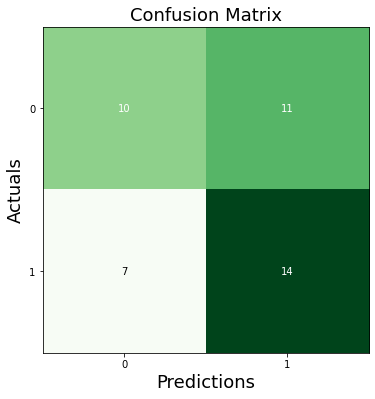

In [72]:
ConfusionMatrix(y_test_us,y_pred_us)

In [73]:
recall_value_us = get_recall_value(y_test_us,y_pred_us)
recall_value_us 

0.67

**Apply Weights to do penalty on defect cases to force loss function to make defects must be correctly classified**

In [74]:
y_weight = pd.DataFrame(df[target])
y_weight["Weighted"]=compute_sample_weight("balanced",y_weight[target])
display(y_weight.head())
display(y_weight.value_counts())

,Pass/Fail,Weighted
0,-1,0.535543
1,-1,0.535543
2,1,7.533654
3,-1,0.535543
4,-1,0.535543


Pass/Fail  Weighted
-1         0.535543    1463
 1         7.533654     104
dtype: int64

In [75]:
weight_value = y_weight["Weighted"].unique()
weight_value

array([0.5355434 , 7.53365385])

In [76]:
weight_values = [weight_value[0] if value == 0 else weight_value[1] for value in y_train_us]

In [77]:
model_us_weight = xgb.XGBClassifier(eval_metric='logloss',random_state=10)
model_us_weight.fit(X_train_us,y_train_us,sample_weight=weight_values)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=10, ...)

[[ 9 12]
 [ 3 18]]
              precision    recall  f1-score   support

           0       0.75      0.43      0.55        21
           1       0.60      0.86      0.71        21

    accuracy                           0.64        42
   macro avg       0.68      0.64      0.63        42
weighted avg       0.68      0.64      0.63        42



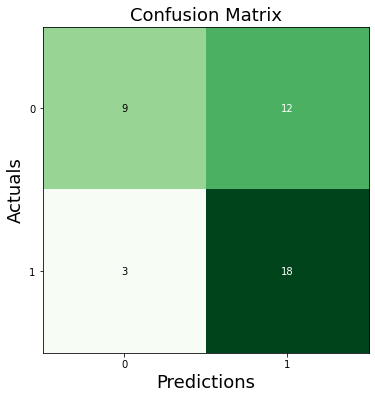

In [78]:
y_pred_us_weight = model_us_weight.predict(X_test_us)
ConfusionMatrix(y_test_us,y_pred_us_weight)

In [79]:
recall_value_us_weight = get_recall_value(y_test_us,y_pred_us_weight)
recall_value_us_weight

0.86

### 3.2 Over sampling data

#### 3.2a Using SMOTE

In [80]:
from sklearn.model_selection import train_test_split
X_os_sm_train,X_os_sm_test,y_os_sm_train,y_os_sm_test = train_test_split(X_os_smote,y_os_smote,test_size=0.2,random_state=0)

In [81]:
import xgboost as xgb
xgb_model_os_SMOTE = xgb.XGBClassifier(objective='binary:logistic',eval_metric='logloss',random_state=123)
xgb_model_os_SMOTE.fit(X_os_sm_train,y_os_sm_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=123, ...)

[[305   2]
 [  5 274]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       307
           1       0.99      0.98      0.99       279

    accuracy                           0.99       586
   macro avg       0.99      0.99      0.99       586
weighted avg       0.99      0.99      0.99       586



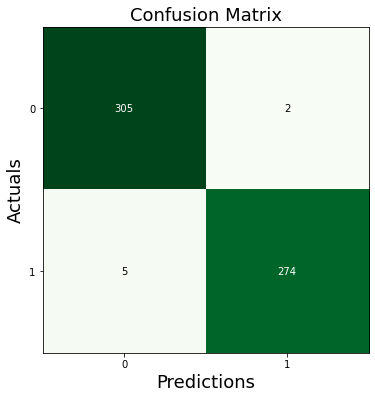

In [82]:
y_os_sm_pred = xgb_model_os_SMOTE.predict(X_os_sm_test)
ConfusionMatrix(y_os_sm_test,y_os_sm_pred)

[[21  0]
 [ 2 19]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        21
           1       1.00      0.90      0.95        21

    accuracy                           0.95        42
   macro avg       0.96      0.95      0.95        42
weighted avg       0.96      0.95      0.95        42



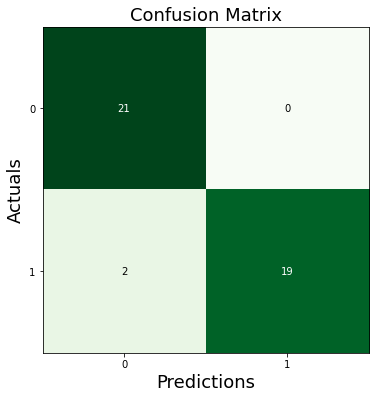

In [83]:
# Using model in SMOTE data to predict undersampling data
ConfusionMatrix(y_test_us,xgb_model_os_SMOTE.predict(X_test_us))

In [84]:
recall_value_os_smote = get_recall_value(y_test_us,xgb_model_os_SMOTE.predict(X_test_us))
recall_value_os_smote

0.9

#### 3.2b Using SVMSMOTE

In [85]:

X_os_svm_train,X_os_svm_test,y_os_svm_train,y_os_svm_test = train_test_split(X_os_svm,y_os_svm,test_size=0.2,random_state=0)

In [86]:
model_os_SVMSMOTE = xgb.XGBClassifier(objective='binary:logistic',eval_metric='logloss',random_state=123)
model_os_SVMSMOTE.fit(X_os_svm_train,y_os_svm_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=123, ...)

In [87]:
y_os_svm_pred = model_os_SVMSMOTE.predict(X_os_svm_test)

[[290   7]
 [ 15  93]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       297
           1       0.93      0.86      0.89       108

    accuracy                           0.95       405
   macro avg       0.94      0.92      0.93       405
weighted avg       0.95      0.95      0.94       405



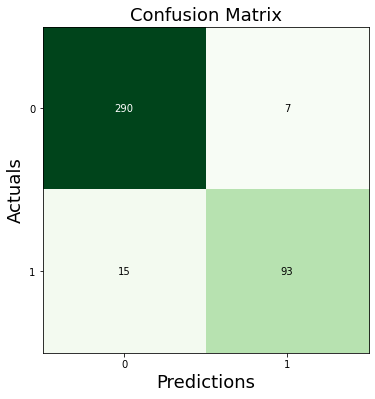

In [88]:
ConfusionMatrix(y_os_svm_test,y_os_svm_pred)

[[21  0]
 [ 2 19]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        21
           1       1.00      0.90      0.95        21

    accuracy                           0.95        42
   macro avg       0.96      0.95      0.95        42
weighted avg       0.96      0.95      0.95        42



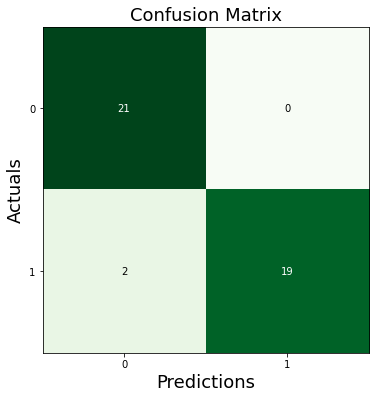

In [89]:
# Test model of svm data in undersampling data
ConfusionMatrix(y_test_us,model_os_SVMSMOTE.predict(X_test_us))

In [90]:
recall_value_os_svm = get_recall_value(y_test_us,model_os_SVMSMOTE.predict(X_test_us))
recall_value_os_svm

0.9

## 4. Summary

In [91]:
summary_table = pd.DataFrame({"Model":["Undersampling","Undersampling with Weight","SMOTE","SMOTE with SVM"],"Recall":[recall_value_us,recall_value_us_weight,recall_value_os_smote,recall_value_os_svm]},index=[1,2,3,4])
summary_table

,Model,Recall
1,Undersampling,0.67
2,Undersampling with Weight,0.86
3,SMOTE,0.90
4,SMOTE with SVM,0.90


Conclusion:
+ We get highest value when using "SMOTE and SMOTE with SVM"
+ Under sampling with weight can increase recall value when using under sampling
